In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA

In [70]:
# extract raw data and epoch it 
raw = mne.io.read_raw_eeglab('sep_uwgr_prepro.set', preload=False)
events, event_id = mne.events_from_annotations(raw)

tmin = -0.05
tmax = 0.22

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=None, preload=True)

Reading /data/u_brenner_software/eeg_data_analysis/eeg_llm/sep_uwgr_prepro.fdt


/tmp/ipykernel_2384273/3993384952.py:2: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_raw_eeglab('sep_uwgr_prepro.set', preload=False)


Used Annotations descriptions: ['1']
Not setting metadata
6038 matching events found
No baseline correction applied
0 projection items activated
Loading data for 6038 events and 554 original time points ...
0 bad epochs dropped


In [14]:
epochs.drop_bad()

Loading data for 6038 events and 554 original time points ...
0 bad epochs dropped


Number of events,6038
Events,1: 6038
Time range,-0.050 – 0.220 s
Baseline,off


In [71]:
# Load custom montage from your .elc file
montage = mne.channels.read_custom_montage('waveguard256_duke_ug110527_adapted.elc')

# Apply the custom montage to the raw data
raw.set_montage(montage)

# Apply the custom montage to the epochs as well
epochs.set_montage(montage)

/tmp/ipykernel_2384273/1236532055.py:5: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)
/tmp/ipykernel_2384273/1236532055.py:8: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Number of events,6038
Events,1: 6038
Time range,-0.050 – 0.220 s
Baseline,off


In [72]:
import pandas as pd

# Path to your head shape points file
head_shape_file_path = 'head_positions.txt'

# Read the head shape points file
with open(head_shape_file_path, 'r') as file:
    lines = file.readlines()

# Find the start of the head shape points
start_idx = lines.index('HeadShapePoints\n') + 1

# Read the points into a DataFrame
head_shape_points = pd.read_csv(head_shape_file_path, delim_whitespace=True, header=None, skiprows=start_idx)
head_shape_points.columns = ['x', 'y', 'z']

# Convert the points from millimeters to meters
head_shape_points = head_shape_points / 1000.0

# Convert the points to MNE's DigMontage format
# Assuming the first three points are nasion, lpa, and rpa respectively
nasion = head_shape_points.iloc[0].values.tolist()
lpa = head_shape_points.iloc[1].values.tolist()
rpa = head_shape_points.iloc[2].values.tolist()
hsp = head_shape_points.iloc[3:].values.tolist()

# Create a DigMontage for head shape points
head_shape_montage = mne.channels.make_dig_montage(
    nasion=nasion,
    lpa=lpa,
    rpa=rpa,
    hsp=hsp,
    coord_frame='head'
)

# Combine the original montage with the head shape montage
combined_montage = montage + head_shape_montage

# Apply the combined montage to the raw data
raw.set_montage(combined_montage)

# Apply the combined montage to the epochs as well
epochs.set_montage(combined_montage)


/tmp/ipykernel_2384273/4077012576.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  head_shape_points = pd.read_csv(head_shape_file_path, delim_whitespace=True, header=None, skiprows=start_idx)


Number of events,6038
Events,1: 6038
Time range,-0.050 – 0.220 s
Baseline,off


In [182]:
ica = ICA(n_components=15, random_state=97, max_iter=800)

In [36]:
# Loop over each epoch
for epoch_idx in range(3):
    epoch = epochs[epoch_idx]  # Extract the individual epoch

    # Fit ICA to the epoch
    ica.fit(epoch)

    # Apply ICA to the epoch to get the sources
    sources = ica.get_sources(epoch)

    # Here you can analyze the sources or save them as needed
    # For now, let's just print the shape of the sources to confirm
    print(f'Epoch {epoch_idx+1}/3: sources shape = {sources.get_data().shape}')

Fitting ICA to data using 253 channels (please be patient, this may take a while)


Loading data for 1 events and 554 original time points ...
0 bad epochs dropped


/tmp/ipykernel_2384273/2179164805.py:6: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(epoch)


Selecting by number: 50 components
Loading data for 1 events and 554 original time points ...
Fitting ICA took 8.7s.
Loading data for 1 events and 554 original time points ...
Epoch 1/3: sources shape = (1, 50, 554)
Fitting ICA to data using 253 channels (please be patient, this may take a while)
Loading data for 1 events and 554 original time points ...
0 bad epochs dropped


/tmp/ipykernel_2384273/2179164805.py:13: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  print(f'Epoch {epoch_idx+1}/3: sources shape = {sources.get_data().shape}')
/tmp/ipykernel_2384273/2179164805.py:6: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(epoch)


Selecting by number: 50 components
Loading data for 1 events and 554 original time points ...
Fitting ICA took 10.3s.
Loading data for 1 events and 554 original time points ...
Epoch 2/3: sources shape = (1, 50, 554)
Fitting ICA to data using 253 channels (please be patient, this may take a while)
Loading data for 1 events and 554 original time points ...
0 bad epochs dropped


/tmp/ipykernel_2384273/2179164805.py:13: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  print(f'Epoch {epoch_idx+1}/3: sources shape = {sources.get_data().shape}')
/tmp/ipykernel_2384273/2179164805.py:6: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(epoch)


Selecting by number: 50 components
Loading data for 1 events and 554 original time points ...
Fitting ICA took 9.7s.
Loading data for 1 events and 554 original time points ...
Epoch 3/3: sources shape = (1, 50, 554)


/tmp/ipykernel_2384273/2179164805.py:13: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  print(f'Epoch {epoch_idx+1}/3: sources shape = {sources.get_data().shape}')


In [183]:
first_epoch = epochs[:1].copy().load_data()
first_epoch_data = first_epoch.get_data()
_, n_channels, n_times = first_epoch_data.shape

first_epoch_data = first_epoch_data.transpose(1,0,2).reshape(n_channels, n_times)

info = first_epoch.info.copy()
first_epoch_raw = mne.io.RawArray(first_epoch_data, info)

Creating RawArray with float64 data, n_channels=253, n_times=554
    Range : 0 ... 553 =      0.000 ...     0.270 secs
Ready.


/tmp/ipykernel_2384273/3774979958.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  first_epoch_data = first_epoch.get_data()


Fitting ICA to data using 253 channels (please be patient, this may take a while)


/tmp/ipykernel_2384273/2873821336.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(first_epoch_raw)


Selecting by number: 15 components
Fitting ICA took 3.2s.


/data/u_brenner_software/miniconda3/envs/mne/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


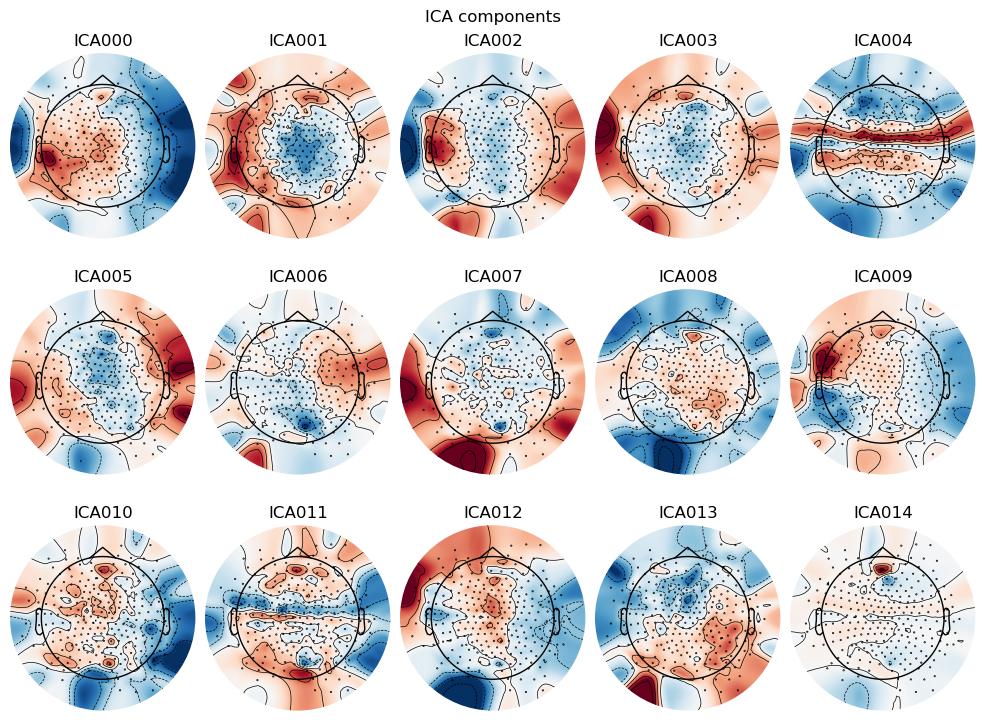

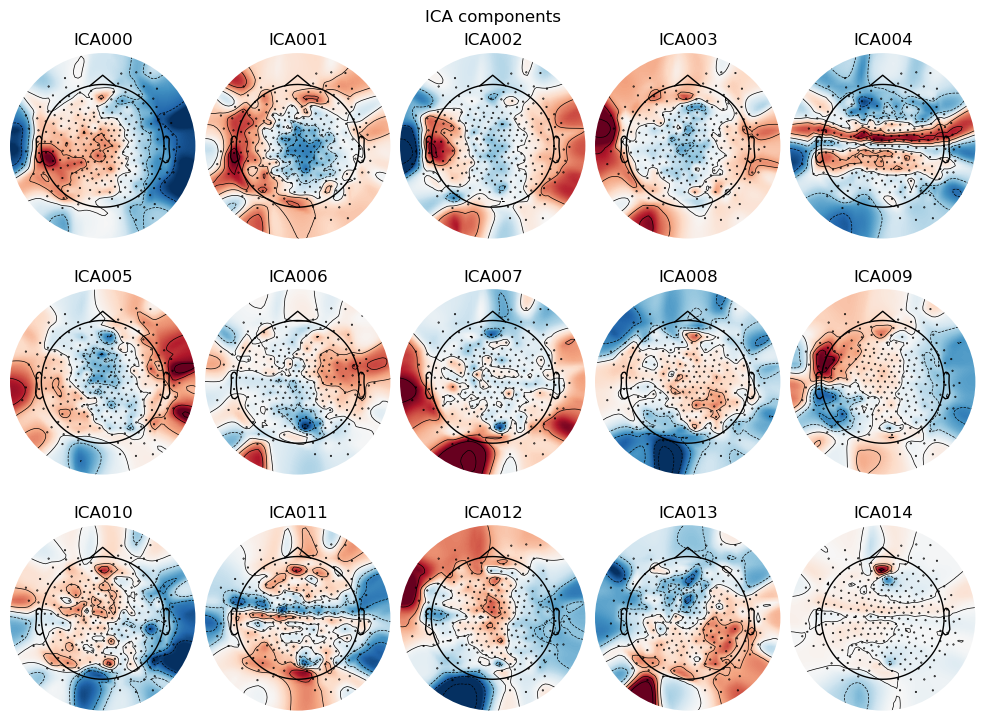

In [184]:
# Example for the first processed epoch
ica.fit(first_epoch_raw)
sources = ica.get_sources(first_epoch_raw)

# Plot the ICA components
ica.plot_components()

In [221]:
reconstructed_data = first_epoch_raw.copy()
ica.apply(reconstructed_data, exclude=[i for i in range(2,15)])

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 13 ICA components
    Projecting back using 253 PCA components


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,442 points
Good channels,253 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.00 Hz
Lowpass,1024.00 Hz


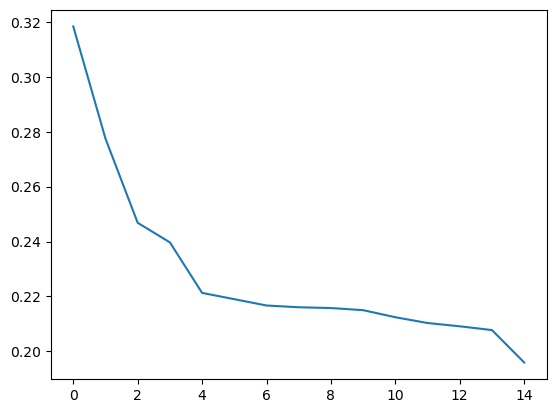

In [278]:
plt.plot([ica.get_explained_variance_ratio(first_epoch_raw,components=[j for j in range(i,i+1)])['eeg'] for i in range(15)])

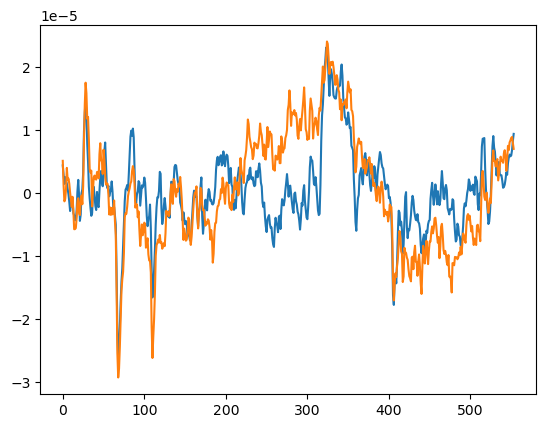

In [229]:
ch = 150
plt.plot(reconstructed_data.get_data()[ch])
plt.plot(first_epoch_raw.get_data()[ch])

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 14 ICA components
    Projecting back using 253 PCA components


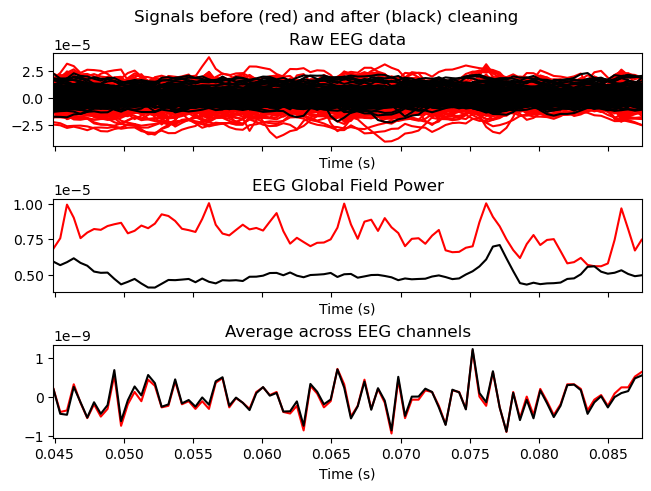

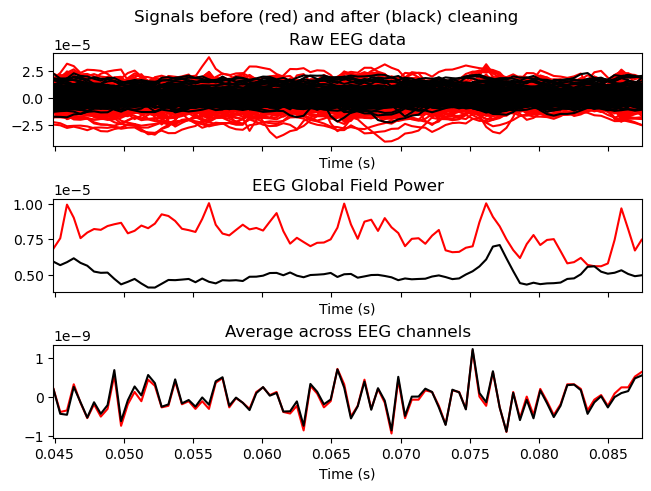

In [282]:
t1, t2 = -0.005-tmin, 0.038-tmin

ica.plot_overlay(first_epoch_raw, exclude=[i for i in range(15) if i != 1], start=t1, stop=t2)